# Tutorial: Using `fastai.data` low-level APIs

> Using `DataSource`, `Pipeline`, `TfmdList`, `TfmOver`, and `Transform`

In [1]:
from local.imports import *
from local.test import *
from local.core import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.vision.core import *
from local.data.external import *

In [2]:
from PIL.ImageFile import ImageFile

In [3]:
torch.cuda.set_device(7)

## Overview

- start with list of filenames
- end with iterator of tensor batches
- display a batch
- display a prediction
  - a prediction should be same structure as a batch (?)
- filename -> (image,label)
- image:
  - open
  - make tensor
  - augment (at PIL, image tensor, or batch tensor level)
    - don't apply to valid set; toggle on/off as needed (e.g. fix_dl)
    - same rand for x/y
    - segment needs nearest neighbor, bbox/points need different funcs
  - show: dataset-wide params like cmap and alpha; denorm params; to_cpu
- label:
  - view text (needs state: vocab)
  - get number
- batch:
  - concat tuples
  - normalize
  - CUDA / float tensor
  - augment

### v1

In [4]:
source = untar_data(URLs.MNIST_TINY)/'train'
items = get_image_files(source)
fn = items[0]
img = PIL.Image.open(fn); img

In [5]:
def mk_tensor(im): return tensor(array(im))[None]

In [6]:
imgt = mk_tensor(img)
imgt.shape,type(imgt)

(torch.Size([1, 28, 28]), torch.Tensor)

In [7]:
lbls = items.mapped(parent_label)
itos,stoi = uniqueify(lbls, bidir=True, sort=True)
lbls[0], stoi['3']

('3', 0)

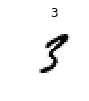

In [8]:
show_image(imgt, title=lbls[0], figsize=(1,1), cmap="Greys");

In [9]:
@patch
def dihedral(im:ImageFile, idx=0): return im.transpose(idx-1) if idx>=1 else im
def rand_dihedral(im): return im.dihedral(random.randint(0,7))

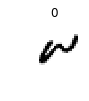

In [10]:
pipe_open = compose(PIL.Image.open, rand_dihedral, mk_tensor)

class MNIST():
    def __getitem__(self,i): return pipe_open(items[i]), stoi[lbls[i]]
    def __len__(self): return len(items)

ds = MNIST()
show_titled_image(ds[0], figsize=(1,1), cmap="Greys")

In [11]:
dl = DataLoader(ds, batch_size=9)
b = next(iter(dl))
x,y = to_device(b)
x = x.float()/255.

In [12]:
def normalize  (o,m,s): return (o-m)/s
def denormalize(o,m,s): return (o*s)+m

def decode_vocab(o, v): return [v[o_] for o_ in o]

In [13]:
m,s = 0.1,0.3
x = normalize(x,m,s)
x.mean(),x.std()

(tensor(0.0556, device='cuda:0'), tensor(0.9651, device='cuda:0'))

In [14]:
denorm = partial(denormalize,m=m,s=s)
decode = partial(decode_vocab, v=itos)

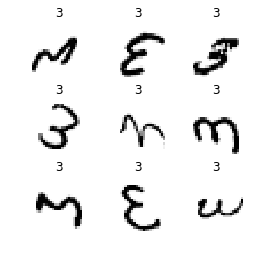

In [15]:
show_image_batch((denorm(x),decode(y)), cmap="Greys", figsize=(4,4))

### v2

In [16]:
vocab = SimpleNamespace(itos=itos,stoi=stoi)

In [17]:
def floatify(o): return o.float()/255.

In [81]:
def _get_types(func):
    sig = inspect.signature(func)
    t_out = sig.return_annotation if sig.return_annotation != inspect._empty else None
    t_in = getattr(next(iter(sig.parameters.items())), 'annotation', None)
    return (t_in,t_out)

def _check_same(t1, t2):
    assert t1 is None or t2 is None or t1 == t2
    return t2 if t1 is None else t1

class Transform():
    def __init__(self, encodes=None):
        if encodes is not None: self.encodes = encodes
        self.__postinit__()
    
    def __postinit__(self):
        self.type_in,self.type_out = _get_types(self.encodes)
        if hasattr(self, 'decodes'):
            t_out,t_in = _get_types(self.decodes)
            self.type_in  = _check_same(self.type_in,  t_in)
            self.type_out = _check_same(self.type_out, t_out)
        self.postinit_done = True
        
    def __call__(self, m, t=None): 
        if not getattr(self, 'postinit_done', False):
            warn(f"You forgot to run super().__init__() at the end of the init of {self.__class__.__name__}!")
        return (self.encodes(m), t if self.type_out is None else self.type_out)
    def decode(self, m, t=None):   
        return (getattr(self, 'decodes', noop)(m), t if self.type_in is None else self.type_in)

In [82]:
class Normalize(Transform):
    def __init__(self, m, s):
        self.m,self.s = m,s
        super().__init__()
    def encodes(self,o): return (o-self.m)/self.s 
    def decodes(self,o): return (o*self.s)+self.m 

norm_mnist = Normalize(m,s)

In [83]:
imgt = floatify(imgt)
imgt.mean(),imgt.std()

(tensor(4.1776e-16), tensor(1.0552e-15))

In [84]:
imgn = norm_mnist(imgt)[0]
imgn.mean(),imgn.std()

(tensor(-0.3333), tensor(0.))

In [85]:
imgt2 = norm_mnist.decode(imgn)[0]
imgt2.mean(),imgt2.std()

(tensor(0.), tensor(0.))

In [86]:
class String():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_title(str(o), ctx=ctx)

In [87]:
String.show("3")

3


In [109]:
class Categorify(Transform):
    def __init__(self, vocab): 
        self.vocab = vocab
        super().__init__()
    def encodes(self, s): return self.vocab.stoi[getattr(s, 'data', s)]
    def decodes(self, i) -> String: return self.vocab.itos[i]

In [110]:
tst = Categorify(vocab)

In [111]:
tst.type_out,tst.type_in

(None, __main__.String)

In [112]:
class TensorImage():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_image(to_cpu(o), ctx=ctx, **kwargs)

In [113]:
def mk_tensor(im) -> TensorImage: return tensor(array(im))[None]

In [114]:
def compose_tfms(x, t, tfms, func_nm='__call__', reverse=False):
    if reverse: tfms = reversed(tfms)
    for tfm in tfms: x,t = getattr(tfm,func_nm,noop)(x, t)
    return x,t

class Pipeline():
    def __init__(self, *tfms): self.tfms = [t if isinstance(t, Transform) else Transform(t) for t in tfms]
    def __call__(self, o, t=None): return compose_tfms(o, t, self.tfms)
    def decode  (self, i, t=None): return compose_tfms(i, t, self.tfms, func_nm='decode', reverse=True)
    def show(self, o, t=None, ctx=None, **kwargs):
        for tfm in reversed(self.tfms):
            if hasattr(t, 'show'): return t.show(o, ctx=ctx, **kwargs)
            o,t = tfm.decode(o,t)
        if hasattr(t, 'show'): return t.show(o, ctx=ctx, **kwargs)

In [115]:
pipe_x = Pipeline(PIL.Image.open, rand_dihedral, mk_tensor)
pipe_y = Pipeline(Categorify(vocab))

In [116]:
class MNIST(): #Missing xy transforms
    def __init__(self, items, lbls, f_x, f_y, t_x=None,t_y=None):
        self.items,self.lbls,self.f_x,self.f_y,self.t_x,self.t_y = items,lbls,f_x,f_y,t_x,t_y
    def __getitem__(self, i): 
        x,self.final_t_x = self.f_x(self.items[i], self.t_x)
        y,self.final_t_y = self.f_y(self.lbls[i],  self.t_y)
        return x,y
    
    def __len__(self): return len(items)
    def show_at(self, i, ctx=None, **kwargs):
        x,y = self[i]
        ctx =  self.f_x.show(x, t=self.final_t_x, ctx=ctx, **kwargs)
        return self.f_y.show(y, t=self.final_t_y, ctx=ctx, **kwargs)

ds = MNIST(items, lbls, pipe_x, pipe_y)

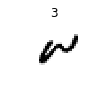

In [117]:
ds.show_at(0, cmap="Greys", figsize=(1,1))

In [118]:
dl = DataLoader(ds, batch_size=9)

In [119]:
class MNIST_DL():
    def __init__(self, dl, f_x, f_y): self.dl,self.f_x,self.f_y = dl,f_x,f_y
    def __iter__(self): 
        for x,y in self.dl:
            t_x = getattr(self.dl.dataset, 'final_t_x', None)
            t_y = getattr(self.dl.dataset, 'final_t_y', None)
            x1,self.final_t_x = self.f_x(x, t_x)
            y1,self.final_t_y = self.f_y(y, t_y)
            yield x1,y1
    def __len__(self): return len(self.dl)
    
    def decode_batch(self, b):
        x,y = b
        (x,t_x) = self.f_x.decode(x, self.final_t_x)
        (y,t_y) = self.f_y.decode(y, self.final_t_y)
        return (x,y),(t_x,t_y)
    
    def show_batch(self, b, max_rows=10, ctxs=None, **kwargs):
        b,ts = self.decode_batch(b) 
        rows = itertools.islice(zip(*L(b)), max_rows)
        if ctxs is None: ctxs = [None] * len(b[0] if is_iter(b[0]) else b)
        for o,ctx in zip(rows,ctxs):
            ctx = self.dl.dataset.f_x.show(o[0], t=ts[0], ctx=ctx, **kwargs)
            self.dl.dataset.f_y.show(o[1], t=ts[1], ctx=ctx, **kwargs)

dl_pipe_x = Pipeline(to_device, floatify, norm_mnist)
dl_pipe_y = Pipeline(to_device)
mdl = MNIST_DL(dl, dl_pipe_x, dl_pipe_y)

In [120]:
b = next(iter(mdl))

In [121]:
b[0].shape,b[1].shape

(torch.Size([9, 1, 28, 28]), torch.Size([9]))

In [122]:
mdl.final_t_x,mdl.final_t_y

(__main__.TensorImage, None)

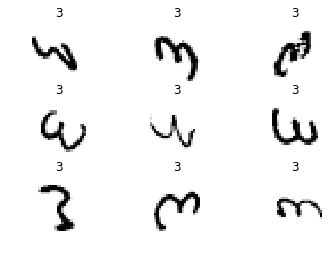

In [123]:
fig,axs = plt.subplots(3,3)
mdl.show_batch(b, cmap="Greys", figsize=(4,4), ctxs=axs.flat)

### v3

In [16]:
vocab = SimpleNamespace(itos=itos,stoi=stoi)

In [17]:
def floatify(o): return o.float()/255.

In [193]:
def tst(a, b=1): return a+b
sig = inspect.signature(tst)

In [194]:
sig.parameters.values()

odict_values([<Parameter "a">, <Parameter "b=1">])

In [204]:
[p.annotation if p.annotation != inspect._empty else None for p in sig.parameters.values() if p.default == inspect._empty]

[None]

In [197]:
ps = [p for p in sig.parameters.values()]

In [200]:
ps[0].default

inspect._empty

In [139]:
isinstance(None, tuple)

False

In [140]:
is_listy9

True

In [141]:
tuple(p.annotation if p.annotation != inspect._empty else None for p in sig.parameters.values())

(None,)

In [291]:
def _get_types(func):
    sig = inspect.signature(func)
    t_out = sig.return_annotation if sig.return_annotation != inspect._empty else None
    t_in = [p.annotation if p.annotation != inspect._empty else None 
            for p in sig.parameters.values() if p.default == inspect._empty]
    if len(t_in) == 1: t_in = t_in[0]
    return (t_in,t_out)

def _check_same(t1, t2):
    assert t1 is None or t2 is None or t1 == t2
    return t2 if t1 is None else t1

class Transform():
    def __init__(self, encodes=None):
        if encodes is not None: self.encodes = encodes
        self.__postinit__()
    
    def __postinit__(self):
        self.type_in,self.type_out = _get_types(self.encodes) if hasattr(self, 'encodes') else (None,None)
        if hasattr(self, 'decodes'):
            t_out,t_in = _get_types(self.decodes)
            self.type_in  = _check_same(self.type_in,  t_in)
            self.type_out = _check_same(self.type_out, t_out)
        self.postinit_done = True
    
    def __call__(self, o, t=None): 
        if not getattr(self, 'postinit_done', False):
            warn(f"You forgot to run super().__init__() at the end of the init of {self.__class__.__name__}!")
        t = t if self.type_out is None else self.type_out
        if is_listy(t) and not is_listy(self.type_in):
            return (tuple(self.encode_with_type(o_, t=t_) for o_,t_ in zip(o,t)),t)
        return (self.encode_with_type(*L(o), t),t)
                
    def decode(self, o, t=None):   
        t = t if self.type_in is None else self.type_in
        if is_listy(t) and not is_listy(self.type_out):
            return (tuple(self.decode_with_type(o_, t=t_) for o_,t_ in zip(o,t)),t)
        return (self.decode_with_type(*L(o), t),t)
    
    def encode_with_type(self, m, t=None): return self.encodes(m)
    def decode_with_type(self, m, t=None): return getattr(self, 'decodes', noop)(m)

In [292]:
class Normalize(Transform):
    def __init__(self, m, s):
        self.m,self.s = m,s
        super().__init__()
    def encode_with_type(self,o,t): return (o-self.m)/self.s if t == TensorImage else o
    def decode_with_type(self,o,t): return (o*self.s)+self.m if t == TensorImage else o

norm_mnist = Normalize(m,s)

In [293]:
imgt = floatify(imgt)
imgt.mean(),imgt.std()

(tensor(5.9587e-33), tensor(1.5050e-32))

In [294]:
imgn = norm_mnist(imgt, TensorImage)[0]
imgn.mean(),imgn.std()

(tensor(-0.3333), tensor(0.))

In [295]:
imgt2 = norm_mnist.decode(imgn, TensorImage)[0]
imgt2.mean(),imgt2.std()

(tensor(0.), tensor(0.))

In [296]:
class String():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_title(str(o), ctx=ctx)

In [297]:
String.show("3")

3


In [298]:
class Categorify(Transform):
    def __init__(self, vocab): 
        self.vocab = vocab
        super().__init__()
    def encodes(self, s): return self.vocab.stoi[getattr(s, 'data', s)]
    def decodes(self, i) -> String: return self.vocab.itos[i]

In [299]:
tst = Categorify(vocab)

In [300]:
tst.type_out,tst.type_in

(None, __main__.String)

In [301]:
class TensorImage():
    @staticmethod
    def show(o, ctx=None, **kwargs): return show_image(to_cpu(o), ctx=ctx, **kwargs)

In [302]:
def mk_tensor(im) -> TensorImage: return tensor(array(im))[None]

In [303]:
def compose_tfms(x, t, tfms, func_nm='__call__', reverse=False):
    if reverse: tfms = reversed(tfms)
    for tfm in tfms: x,t = getattr(tfm,func_nm,noop)(x, t)
    return x,t

class Pipeline():
    def __init__(self, *tfms): self.tfms = [t if isinstance(t, Transform) else Transform(t) for t in tfms]
    def __call__(self, o, t=None): return compose_tfms(o, t, self.tfms)
    def decode  (self, i, t=None): return compose_tfms(i, t, self.tfms, func_nm='decode', reverse=True)
    def show(self, o, t=None, ctx=None, **kwargs):
        for tfm in reversed(self.tfms):
            if hasattr(t, 'show'): return t.show(o, ctx=ctx, **kwargs)
            o,t = tfm.decode(o,t)
        if hasattr(t, 'show'): return t.show(o, ctx=ctx, **kwargs)

In [304]:
pipe_x = Pipeline(PIL.Image.open, rand_dihedral, mk_tensor)
pipe_y = Pipeline(Categorify(vocab))

In [305]:
class MNIST(): #Missing xy transforms
    def __init__(self, items, lbls, f_x, f_y, f_xy, t_x=None,t_y=None):
        self.items,self.lbls,self.f_x,self.f_y,self.f_xy,self.t_x,self.t_y = items,lbls,f_x,f_y,f_xy,t_x,t_y
    def __getitem__(self, i): 
        x,t_x = self.f_x(self.items[i], self.t_x)
        y,t_y = self.f_y(self.lbls[i],  self.t_y)
        (x,y),self.final_t = self.f_xy((x,y), [t_x,t_y])
        return x,y
    
    def __len__(self): return len(items)
    def show_at(self, i, ctx=None, **kwargs):
        x,y = self[i]
        (x,y),(t_x,t_y) = self.f_xy.decode((x,y), self.final_t)
        ctx =  self.f_x.show(x, t=t_x, ctx=ctx, **kwargs)
        return self.f_y.show(y, t=t_y, ctx=ctx, **kwargs)

ds = MNIST(items, lbls, pipe_x, pipe_y, Pipeline())

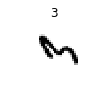

In [306]:
ds.show_at(0, cmap="Greys", figsize=(1,1))

In [307]:
dl = DataLoader(ds, batch_size=9)

In [308]:
class Floatify(Transform):
    def encode_with_type(self, x, t): return getattr(t, 'floatify', noop)(x)

In [316]:
@patch
def floatify(x:TensorImage): return x.float()/255. 

In [317]:
dl_pipe = Pipeline(to_device, Floatify(), norm_mnist)

In [318]:
class MNIST_DL():
    def __init__(self, dl, f): self.dl,self.f = dl,f
    def __iter__(self): 
        for b in self.dl:
            t = getattr(self.dl.dataset, 'final_t', None)
            b,self.final_t = self.f(b,t)
            yield b
    def __len__(self): return len(self.dl)
    
    def decode_batch(self, b):
        return self.f.decode(b, self.final_t)
    
    def show_batch(self, b, max_rows=10, ctxs=None, **kwargs):
        b,ts = self.decode_batch(b) 
        rows = itertools.islice(zip(*L(b)), max_rows)
        if ctxs is None: ctxs = [None] * len(b[0] if is_iter(b[0]) else b)
        for o,ctx in zip(rows,ctxs):
            (x,y),(t_x,t_y) = self.dl.dataset.f_xy.decode(o, ts)
            ctx = self.dl.dataset.f_x.show(x, t=t_x, ctx=ctx, **kwargs)
            self.dl.dataset.f_y.show(y, t=t_y, ctx=ctx, **kwargs)

mdl = MNIST_DL(dl, dl_pipe)

In [319]:
b = next(iter(mdl))

In [320]:
b[0].shape,b[1].shape

(torch.Size([9, 1, 28, 28]), torch.Size([9]))

In [321]:
mdl.final_t

[__main__.TensorImage, None]

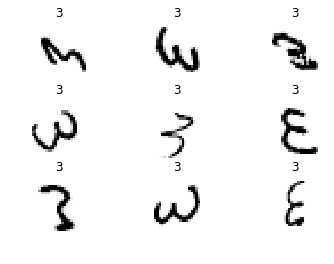

In [322]:
fig,axs = plt.subplots(3,3)
mdl.show_batch(b, cmap="Greys", figsize=(4,4), ctxs=axs.flat)